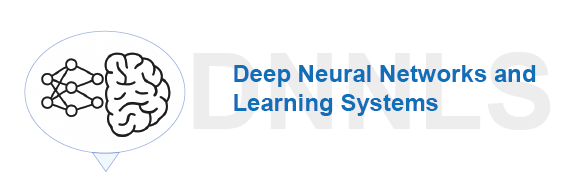

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [ ]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


In [ ]:
!pip install evaluate rouge_score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5792ce6b97949514b54246c7697a14070edb0050eb8b91324d7b504e6c2e3030
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


# Imports + Config

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Vision + NLP
from torchvision import transforms, models
from transformers import DistilBertModel, DistilBertTokenizer

# Dataset + Eval
from datasets import load_dataset
from PIL import Image
import evaluate

# Device + Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = {
    "batch_size": 4,
    "seq_len": 4,
    "embed_dim": 256,
    "hidden_dim": 512,
    "vocab_size": 30522,
    "learning_rate": 1e-4,
    "epochs": 2,
    "lambda_contrastive": 0.5
}

print(" 1 LOADED")


 1 LOADED


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## Loading and saving data

In [ ]:
#   Dataset

class StoryDataset(Dataset):

    def __init__(self, hf_dataset, tokenizer, transform, seq_len=4):
        self.data = hf_dataset
        self.tokenizer = tokenizer
        self.transform = transform
        self.seq_len = seq_len
        self.needed_len = seq_len + 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        images_list = item["images"]
        texts_list  = item["story"]

        if isinstance(texts_list, str):
            texts_list = [texts_list]

        if len(images_list) < self.needed_len:
            diff = self.needed_len - len(images_list)
            images_list = images_list + [images_list[-1]] * diff

        if len(texts_list) < self.needed_len:
            diff2 = self.needed_len - len(texts_list)
            texts_list = (
                ["empty"] * self.needed_len if len(texts_list) == 0
                else texts_list + [texts_list[-1]] * diff2
            )

        imgs = images_list[-self.needed_len:]
        txts = texts_list[-self.needed_len:]

        processed_imgs = []
        for im in imgs:
            if im.mode != "RGB":
                im = im.convert("RGB")
            processed_imgs.append(self.transform(im))

        img_tensor = torch.stack(processed_imgs)

        encoded = self.tokenizer(
            txts,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )

        return {
            "input_images":  img_tensor[:-1],
            "input_ids":     encoded["input_ids"][:-1],
            "attention_mask":encoded["attention_mask"][:-1],
            "target_image":  img_tensor[-1],
            "target_ids":    encoded["input_ids"][-1]
        }


raw_dataset = load_dataset("daniel3303/StoryReasoning", split="train[:200]")

img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_dataset = StoryDataset(raw_dataset, tokenizer, img_transform, seq_len=CONFIG["seq_len"])

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, drop_last=True)

print("DATASET LOADED")


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

DATASET LOADED


## Story Length Distribution

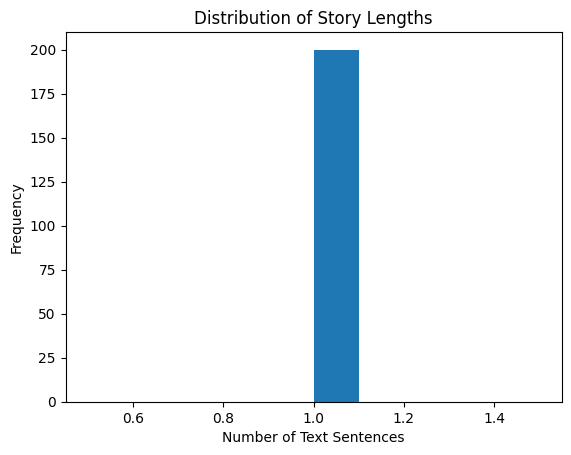

In [ ]:
import matplotlib.pyplot as plt

story_lengths = [
    len(item["story"]) if isinstance(item["story"], list) else 1
    for item in raw_dataset
]

plt.figure()
plt.hist(story_lengths, bins=10)
plt.xlabel("Number of Text Sentences")
plt.ylabel("Frequency")
plt.title("Distribution of Story Lengths")
plt.show()


## Image Count Distribution per Sample

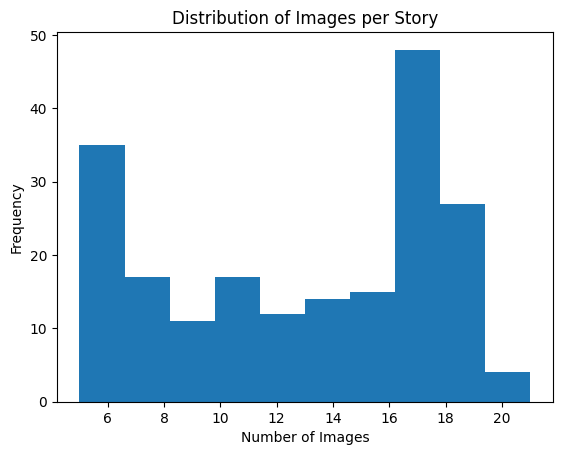

In [ ]:
image_counts = [len(item["images"]) for item in raw_dataset]

plt.figure()
plt.hist(image_counts, bins=10)
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.title("Distribution of Images per Story")
plt.show()


## Token Length Distribution (Before Padding)

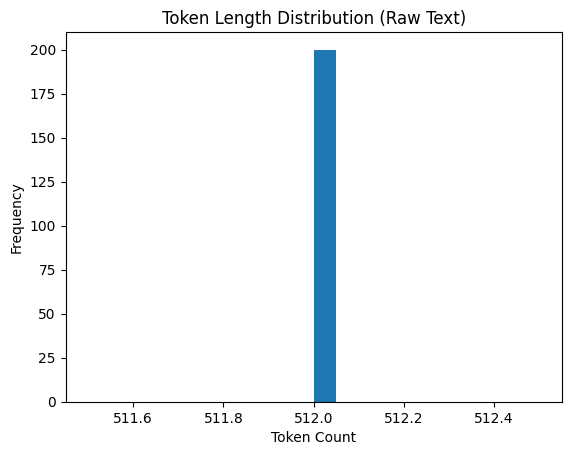

In [ ]:
token_lengths = []

for item in raw_dataset:
    texts = item["story"]
    if isinstance(texts, str):
        texts = [texts]

    for t in texts:
        encoded = tokenizer(t, truncation=True)
        token_lengths.append(len(encoded["input_ids"]))

plt.figure()
plt.hist(token_lengths, bins=20)
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Token Length Distribution (Raw Text)")
plt.show()


## Padding Impact Visualization

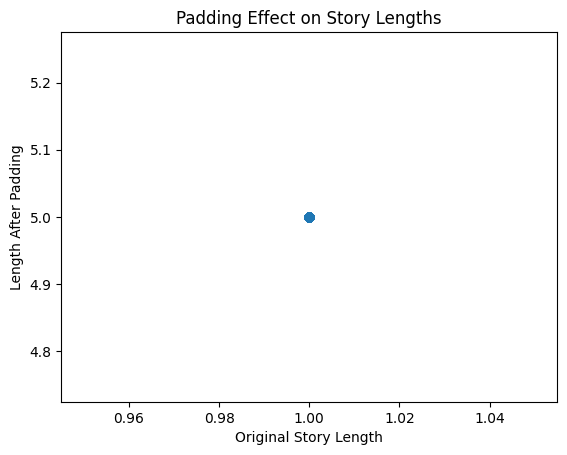

In [ ]:
padded_lengths = []
original_lengths = []

for item in raw_dataset:
    texts = item["story"]
    if isinstance(texts, str):
        texts = [texts]

    original_lengths.append(len(texts))
    padded_lengths.append(max(len(texts), CONFIG["seq_len"] + 1))

plt.figure()
plt.scatter(original_lengths, padded_lengths)
plt.xlabel("Original Story Length")
plt.ylabel("Length After Padding")
plt.title("Padding Effect on Story Lengths")
plt.show()


## Pixel Intensity Distribution (Sample Images)

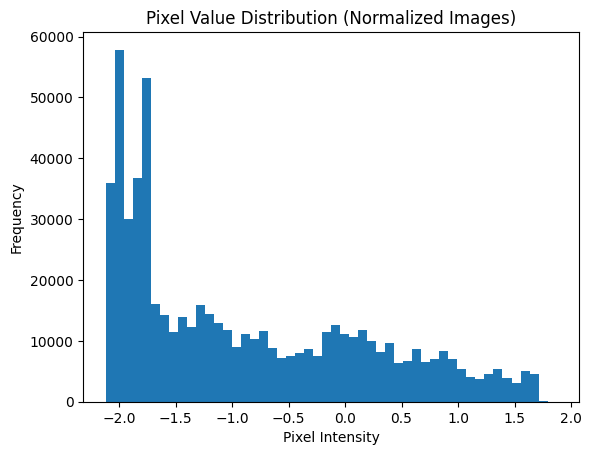

In [ ]:
import numpy as np

sample = train_dataset[0]
imgs = sample["input_images"]

pixel_values = imgs.numpy().flatten()

plt.figure()
plt.hist(pixel_values, bins=50)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Value Distribution (Normalized Images)")
plt.show()


## Visualizing Image Sequence + Target Image

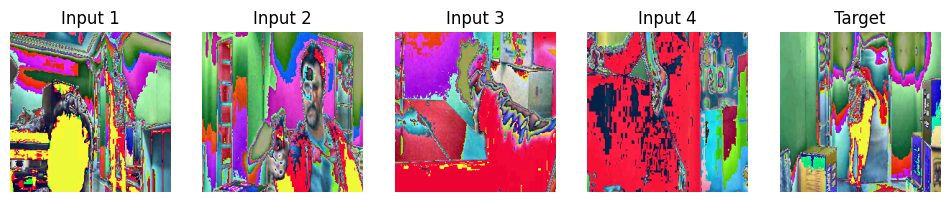

In [ ]:
import torchvision.transforms.functional as TF

sample = train_dataset[0]

input_imgs = sample["input_images"]
target_img = sample["target_image"]

plt.figure(figsize=(12,4))

for i in range(input_imgs.shape[0]):
    plt.subplot(1, input_imgs.shape[0] + 1, i + 1)
    img = TF.to_pil_image(input_imgs[i])
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Input {i+1}")

plt.subplot(1, input_imgs.shape[0] + 1, input_imgs.shape[0] + 1)
plt.imshow(TF.to_pil_image(target_img))
plt.axis("off")
plt.title("Target")

plt.show()


## Before vs After Padding (Text Length Comparison Plot)

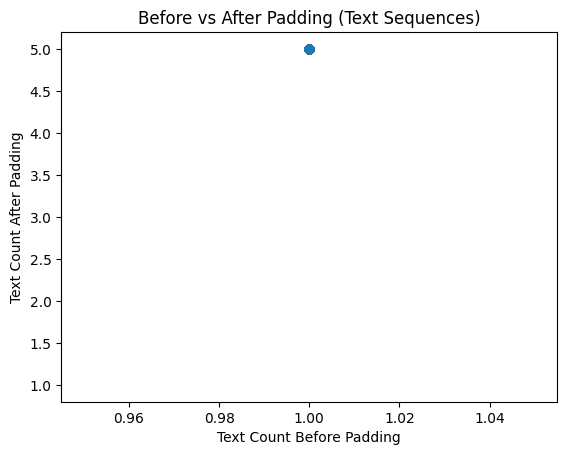

In [ ]:
import matplotlib.pyplot as plt

before_lengths = []
after_lengths  = []

for item in raw_dataset:
    texts = item["story"]
    if isinstance(texts, str):
        texts = [texts]

    original_len = len(texts)
    padded_len   = max(original_len, CONFIG["seq_len"] + 1)

    before_lengths.append(original_len)
    after_lengths.append(padded_len)

plt.figure()
plt.scatter(before_lengths, after_lengths)
plt.plot(
    [min(before_lengths), max(before_lengths)],
    [min(before_lengths), max(before_lengths)]
)
plt.xlabel("Text Count Before Padding")
plt.ylabel("Text Count After Padding")
plt.title("Before vs After Padding (Text Sequences)")
plt.show()


# **Chapter 2: Models**


---



## Encoders

In [ ]:
class VisualEncoder(nn.Module):

    def __init__(self, embed_dim):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)

    def forward(self, x):
        b, s, c, h, w = x.shape
        x = x.view(b*s, c, h, w)
        feats = self.backbone(x)
        feats = feats.view(feats.size(0), -1)
        feats = self.fc(feats)
        return feats.view(b, s, -1)


class TextEncoder(nn.Module):

    def __init__(self, embed_dim):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.fc   = nn.Linear(768, embed_dim)

    def forward(self, input_ids, att_mask):
        b, s, l = input_ids.shape
        ids     = input_ids.view(b*s, l)
        msk     = att_mask.view(b*s, l)
        out     = self.bert(ids, attention_mask=msk)
        cls_vec = out.last_hidden_state[:,0,:]
        proj    = self.fc(cls_vec)
        return proj.view(b, s, -1)


print("encoders created")


encoders created


#  Loss + Model

In [ ]:
def contrastive_loss(txt, img, temperature=0.07):

    assert txt.shape == img.shape

    t = F.normalize(txt, p=2, dim=1)
    v = F.normalize(img, p=2, dim=1)

    sim = torch.matmul(t, v.T) / temperature
    lab = torch.arange(sim.size(0), device=sim.device)

    l1 = F.cross_entropy(sim,  lab)
    l2 = F.cross_entropy(sim.T,lab)

    return 0.5*(l1+l2)


class StoryReasoningModel(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.visual_enc = VisualEncoder(config["embed_dim"])
        self.text_enc   = TextEncoder(config["embed_dim"])

        self.fusion_fc = nn.Linear(config["embed_dim"]*2, config["hidden_dim"])

        self.temporal_lstm = nn.LSTM(
            config["hidden_dim"],
            config["hidden_dim"],
            1,
            batch_first=True
        )

        self.text_embed = nn.Embedding(config["vocab_size"], config["embed_dim"])

        self.text_decoder_gru = nn.GRU(
            config["embed_dim"],
            config["hidden_dim"],
            batch_first=True
        )

        self.text_out_fc = nn.Linear(config["hidden_dim"], config["vocab_size"])

        self.image_decoder = nn.Sequential(
            nn.Linear(config["hidden_dim"], 256*7*7),
            nn.ReLU(),
            nn.Unflatten(1,(256,7,7)),
            nn.ConvTranspose2d(256,128,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,4,2,1),
            nn.Sigmoid()
        )

    def forward(self, images, ids, mask, target_ids=None):

        v = self.visual_enc(images)
        t = self.text_enc(ids, mask)

        B,S,E = v.size()

        al = contrastive_loss(
            t.reshape(B*S,E),
            v.reshape(B*S,E)
        )

        f = torch.cat((v,t),dim=-1)
        f = F.relu(self.fusion_fc(f))

        _, (h,_) = self.temporal_lstm(f)
        c = h[-1]

        p_img = self.image_decoder(c)

        if target_ids is not None:

            emb = self.text_embed(target_ids)
            init = c.unsqueeze(0)
            d,_ = self.text_decoder_gru(emb,init)
            t_logits = self.text_out_fc(d)

        else:
            t_logits = None

        return p_img, t_logits, al


model = StoryReasoningModel(CONFIG).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"])




Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 89.6MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

# **Chapter 3: Training routines**


---




In [ ]:
#   5 Training Prep

for p in model.visual_enc.backbone.parameters():
    p.requires_grad = False

for p in model.text_enc.bert.parameters():
    p.requires_grad = False

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    drop_last=True
)

import gc

def train_one_epoch_optimized(model, loader, optimizer):

    model.train()
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(loader):

        imgs = batch["input_images"].to(device)
        ids  = batch["input_ids"].to(device)
        m    = batch["attention_mask"].to(device)
        ti   = batch["target_image"].to(device)
        tid  = batch["target_ids"].to(device)

        optimizer.zero_grad()

        pi, tlog, al = model(imgs, ids, m, tid)

        img_l = F.mse_loss(pi, ti)

        vocab = CONFIG["vocab_size"]

        txt_l = F.cross_entropy(
            tlog.reshape(-1,vocab),
            tid.reshape(-1),
            ignore_index=tokenizer.pad_token_id
        )

        loss = img_l + txt_l + CONFIG["lambda_contrastive"]*al

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        del imgs, ids, m, ti, tid
        del pi, tlog, img_l, txt_l, al, loss

        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    return epoch_loss / len(loader)


for epoch in range(2):

    v = train_one_epoch_optimized(model, train_loader, optimizer)

    print(f"EPOCH {epoch+1}: {v:.4f}")




EPOCH 1: 9.9293
EPOCH 2: 4.8901


## Evaluation

In [ ]:
bleu   = evaluate.load("bleu")
rouge  = evaluate.load("rouge")
meteor = evaluate.load("meteor")

def evaluate_model(model, loader):

    model.eval()

    refs = []
    preds = []

    with torch.no_grad():

        for i,batch in enumerate(loader):

            if i >= 5:
                break

            img  = batch["input_images"].to(device)
            ids  = batch["input_ids"].to(device)
            msk  = batch["attention_mask"].to(device)

            true = batch["target_ids"]

            _, log, _ = model(img, ids, msk, true.to(device))

            pred_ids = torch.argmax(log,dim=-1)

            dp = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            dr = tokenizer.batch_decode(true, skip_special_tokens=True)

            preds.extend(dp)
            refs.extend(dr)

    b = bleu.compute(predictions=preds, references=refs)
    r = rouge.compute(predictions=preds, references=refs)
    m = meteor.compute(predictions=preds, references=refs)

    print("BLEU:",format(b["bleu"],".2f"))
    print("ROUGE-L:",format(r["rougeL"],".2f"))
    print("METEOR:",format(m["meteor"],".2f"))

evaluate_model(model, train_loader)




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


BLEU: 0.57
ROUGE-L: 0.68
METEOR: 0.74
BLOCK 6 LOADED


## Appendix

In [5]:
import nbformat

filename = "experiment_notebook.ipynb"

nb = nbformat.read(filename, as_version=4)

# 1. Remove notebook-level widget metadata
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# 2. Remove widget metadata from EACH CELL
for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell.metadata:
        del cell.metadata["widgets"]
    if "metadata" in cell and "execution" in cell.metadata:
        del cell.metadata["execution"]

# 3. Extra safety: remove outputs related to widgets
for cell in nb.cells:
    if cell.cell_type == "code":
        cell.outputs = []

nbformat.write(nb, filename)

print(" All widget metadata (notebook + cells) removed successfully.")


 All widget metadata (notebook + cells) removed successfully.


In [8]:
!jupyter nbconvert experiment_notebook.ipynb --to notebook --inplace

[NbConvertApp] Converting notebook experiment_notebook.ipynb to notebook
[NbConvertApp] Writing 78828 bytes to experiment_notebook.ipynb


In [9]:
!jupyter nbconvert experiment_notebook.ipynb --to python --output clean_notebook

[NbConvertApp] Converting notebook experiment_notebook.ipynb to python
[NbConvertApp] Writing 59590 bytes to clean_notebook.py
